In [1]:
import os
os.listdir('./data')

['train_spec_checked(2016~2017).csv',
 'train_FeatureSelected(2016~2017).csv',
 'train_KnnFilled(2017~2018).csv',
 'train_KnnFilled(2016~2017).csv',
 'train_KnnFilled(2018~2019).csv',
 'train_KnnFilled(full).csv',
 'train_spec_checked(full).csv']

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import collections
from tqdm import tqdm_notebook as tqdm

# load df

In [3]:
file_path = './data/train_KnnFilled(full).csv'

In [4]:
df = pd.read_csv(file_path, index_col = 0, parse_dates = True)
print(df.shape)
df.head()

(193824, 93)


,MLPAP_TI-0706B02,MLPAP_TI-0706B03,MLPAP_TI-0706B04,MLPAP_TI-0706B05,MLPAP_TI-0706B06,MLPAP_TI-0706B07,MLPAP_TI-0706B08,MLPAP_TI-0706B09,MLPAP_TI-0706B10,MLPAP_TI-0706B11,...,MLPAP_FQI-0997.PV,DATA OF USE,MLPAP_FR-0755.PV,MLPAP_FR-0755PV(轉換後),MLPAP_FR-0791.PV,MLPAP_FI-V211.PV,MLPAP_FI-V211.PV(轉換後),MLPAP_PI-0658.PV,MLPAP_TIC-0757.PV,MLPAP_V125-PHD
2016-05-09 00:00:00,399.996956,401.962157,400.757148,402.245915,401.143639,400.998932,400.048649,402.996307,402.001481,400.999089,...,-0.026063,3.342795,4.050917,4.045456,6.484379,0.089541,0.08942,-1.007740,1.635430,0.050999
2016-05-09 00:10:00,399.996956,401.939352,400.954632,402.245915,401.004025,400.998932,400.244686,402.996307,402.001481,400.999089,...,-0.026063,3.342795,4.157893,4.152288,6.449854,0.089541,0.08942,-1.007740,1.624784,0.050999
2016-05-09 00:20:00,399.996956,401.905143,400.896549,402.104563,401.004025,400.998932,400.094776,402.996307,402.001481,400.999089,...,-0.026063,3.342795,4.207893,4.202220,6.440330,0.089541,0.08942,-0.905851,1.649624,0.050999
2016-05-09 00:30:00,399.996956,401.950754,400.896549,402.304812,401.004025,400.998932,400.140902,402.996307,402.001481,400.999089,...,-0.026063,3.342795,4.152079,4.146482,6.464140,0.089541,0.08942,-0.518671,1.635430,0.050999
2016-05-09 00:40:00,399.996956,401.996366,400.850082,402.175239,401.004025,400.998932,400.406128,402.996307,402.001481,400.999089,...,-0.026063,3.342795,4.016615,4.011200,6.415329,0.089541,0.08942,-0.987362,1.653172,0.050999


# spec

In [5]:
tag_sheet = pd.read_excel('tag盤點表.xlsx')
intersection = set(tag_sheet['TAG'].values)&set(df.columns.tolist())
spec = tag_sheet[tag_sheet['TAG'].isin(intersection)][['TAG','chinese','min','max']].set_index('TAG')
spec.loc['DATA OF USE','min'],spec.loc['DATA OF USE','max'] = 0,np.inf
print(spec.shape[0])
print("保留的欄位")
spec

67
保留的欄位


,chinese,min,max
TAG,,,
MLPAP_TJC-0627.PV,OX預熱器出口溫度,140,160
MLPAP_TRC-0610.PV,空氣預熱器出口溫度,160,200
MLPAP_FR-0632.PV,汽機風量,30,90
MLPAP_FQ-0619.PV,OX入料量,2000,8000
MLPAP_TIC-0757A.PV,反應槽鹽浴溫度,345,365
...,...,...,...
MLPAP_TJR-0762B1.PV,鹽浴溫度,345,375
MLPAP_TJR-0762B2.PV,鹽浴溫度,345,375
MLPAP_PI-0658.PV,反應器入口壓力,200,500


In [6]:
df = df[spec.index.tolist()]
print(df.shape)

(193824, 67)


# column filter

In [7]:
def check_spec_col(df,spec):
    count = collections.defaultdict(int)
    intersection = set(list(df.columns))&set(list(spec.index))
    for col in tqdm(list(intersection)):
        lb, ub = spec.loc[col,'min'], spec.loc[col,'max']
        over_range = (df[col]<lb)|(df[col]>ub)
        count[col] += over_range.sum()
    return pd.DataFrame(count.values(),index=count.keys(),columns=['count'])['count']

In [8]:
count = check_spec_col(df,spec)
count

/workspace/conda/lib/python3.6/site-packages/ipykernel_launcher.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  after removing the cwd from sys.path.


MLPAP_TI-0706B03        42917
MLPAP_TI-0706B07        42957
MLPAP_TI-0706B20        43013
MLPAP_TI-0706C01        47122
MLPAP_TI-0706B14        42826
                        ...  
MLPAP_TI-0706B21        43431
MLPAP_LRC-0729.PV       46273
MLPAP_PIC-0741.PV      160788
MLPAP_TJR-0715A1.PV     42870
MLPAP_TJR-0721.PV      122055
Name: count, Length: 67, dtype: int64

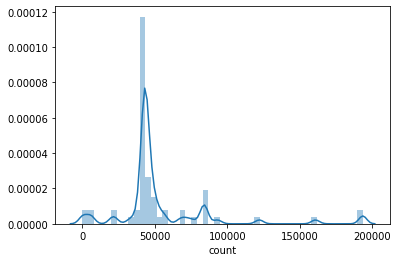

In [9]:
sns.distplot(count)
plt.show()

In [10]:
theshold = count.median()
print(theshold)

43015.0


In [11]:
remain_col = count.loc[count<theshold].index.tolist()
y_col = ['MLPAP_FQ-0619.PV','MLPAP_FQI-0997.PV']
remain_col = list(set(remain_col)|set(y_col)) 
df = df[remain_col]
df.shape

(193824, 35)

In [12]:
spec.loc[spec.index.isin(df.columns)]

,chinese,min,max
TAG,,,
MLPAP_TRC-0610.PV,空氣預熱器出口溫度,160,200
MLPAP_FQ-0619.PV,OX入料量,2000,8000
MLPAP_LIC-0738.PV,汽鼓(V211)鍋爐水液位,20,60
MLPAP_PIC-0761.PV,鹽浴冷卻器(E112)出口壓力,40,55
MLPAP_TIC-1721.PV,轉換式冷凝器冷油溫度,55,68
MLPAP_TRC-1734.PV,轉換式冷凝器熱油溫度,160,200
MLPAP_TI-0706A01,反應槽觸媒溫度(CL1)_高度(1900),340,450
MLPAP_TI-0706E01,反應槽觸媒溫度(CL1)_高度(1310),340,450
MLPAP_TI-0716D01,反應槽觸媒溫度_高度(1650),340,450


# OVER RANGE COUNT

In [13]:
def check_spec(df,spec):
    df['over_range_num'] = 0
    for col in tqdm(df.columns[:-1]):
        lb, ub = spec.loc[col,'min'],spec.loc[col,'max']
        over_range = (df[col]<lb)|(df[col]>ub)
        df.loc[over_range,col] = 'over_range'
        df.loc[over_range,'over_range_num'] += 1
    return df
df = check_spec(df,spec)
df.head()

/workspace/conda/lib/python3.6/site-packages/ipykernel_launcher.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  This is separate from the ipykernel package so we can avoid doing imports until


,MLPAP_TI-0706B03,MLPAP_TI-0706B07,MLPAP_TI-0706B20,MLPAP_TI-0706B14,MLPAP_LIC-0738.PV,MLPAP_TI-0706B11,MLPAP_TI-0706B19,MLPAP_TIC-0757.PV,DATA OF USE,MLPAP_TI-0706B04,...,MLPAP_TI-0706B23,MLPAP_TI-0706E01,MLPAP_TI-0706B06,MLPAP_TI-0706B17,MLPAP_TI-0706B24,MLPAP_FQ-0619.PV,MLPAP_TRC-0610.PV,MLPAP_FR-0755.PV,MLPAP_TJR-0715A1.PV,over_range_num
2016-05-09 00:00:00,401.962,400.999,400.795,402.998,over_range,400.999,402.999,1.63543,3.34279,400.757,...,400.997,400.995,401.144,401.952,401.998,over_range,over_range,4.05092,402.689,4
2016-05-09 00:10:00,401.939,400.999,400.795,403.099,over_range,400.999,402.999,1.62478,3.34279,400.955,...,400.997,400.995,401.004,401.83,401.998,over_range,over_range,4.15789,402.779,4
2016-05-09 00:20:00,401.905,400.999,400.752,402.998,over_range,400.999,402.999,1.64962,3.34279,400.897,...,400.997,400.995,401.004,401.764,401.998,over_range,over_range,4.20789,402.729,4
2016-05-09 00:30:00,401.951,400.999,400.949,403.099,over_range,400.999,402.999,1.63543,3.34279,400.897,...,400.997,400.995,401.004,401.996,401.998,over_range,over_range,4.15208,403.166,4
2016-05-09 00:40:00,401.996,400.999,401.004,403.099,over_range,400.999,402.999,1.65317,3.34279,400.85,...,400.997,400.995,401.004,401.709,401.998,over_range,over_range,4.01662,403.017,4


# over_range to np.nan

In [14]:
df = df.replace('over_range',np.nan)
df.isnull().sum()

MLPAP_TI-0706B03       42917
MLPAP_TI-0706B07       42957
MLPAP_TI-0706B20       43013
MLPAP_TI-0706B14       42826
MLPAP_LIC-0738.PV      37302
MLPAP_TI-0706B11       42933
MLPAP_TI-0706B19       42895
MLPAP_TIC-0757.PV      32742
DATA OF USE                0
MLPAP_TI-0706B04       42983
MLPAP_TI-0716D01       43009
MLPAP_TI-0706B13       42965
MLPAP_FQI-0997.PV      51280
MLPAP_TI-0706B10       42953
MLPAP_PIC-0761.PV      38090
MLPAP_TI-0706B22       43000
MLPAP_TIC-1721.PV       5683
MLPAP_TI-0706B09       42908
MLPAP_TI-0706B05       42873
MLPAP_V125-PHD         20569
MLPAP_TI-0706B02       42992
MLPAP_TRC-1734.PV       6111
MLPAP_TI-0706B18       42989
MLPAP_TI-0706B08       42930
MLPAP_TI-0706A01       43013
MLPAP_TI-0706B16       42899
MLPAP_TI-0706B23       42929
MLPAP_TI-0706E01       42970
MLPAP_TI-0706B06       42945
MLPAP_TI-0706B17       42929
MLPAP_TI-0706B24       42935
MLPAP_FQ-0619.PV       46600
MLPAP_TRC-0610.PV      22385
MLPAP_FR-0755.PV         963
MLPAP_TJR-0715

# fillna

In [15]:
x_col = df.drop(['MLPAP_FQ-0619.PV','MLPAP_FQI-0997.PV'],axis=1).columns.tolist()
df[x_col] = df[x_col].fillna(method='bfill')
df[x_col] = df[x_col].fillna(method='ffill')

# add target

In [16]:
df[df.columns[df.columns.str.contains('0997|0619')]]

,MLPAP_FQI-0997.PV,MLPAP_FQ-0619.PV
2016-05-09 00:00:00,NaN,NaN
2016-05-09 00:10:00,NaN,NaN
2016-05-09 00:20:00,NaN,NaN
2016-05-09 00:30:00,NaN,NaN
2016-05-09 00:40:00,NaN,NaN
...,...,...
2020-01-14 23:10:00,NaN,NaN
2020-01-14 23:20:00,NaN,NaN
2020-01-14 23:30:00,NaN,NaN
2020-01-14 23:40:00,NaN,NaN


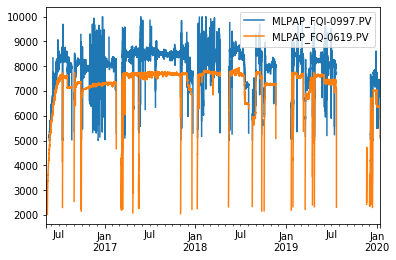

In [17]:
df[df.columns[df.columns.str.contains('0997|0619')]].plot()

In [18]:
df['target'] = df['MLPAP_FQ-0619.PV']/df['MLPAP_FQI-0997.PV']
df = df.drop(['MLPAP_FQ-0619.PV','MLPAP_FQI-0997.PV'],axis=1)

# spec target

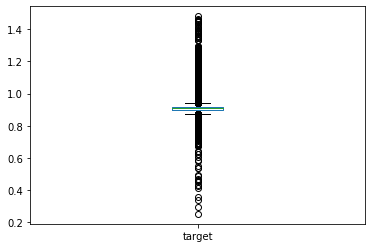

In [19]:
df['target'].plot(kind='box')

# IQR

0.8738874422985881 0.9416781620030912


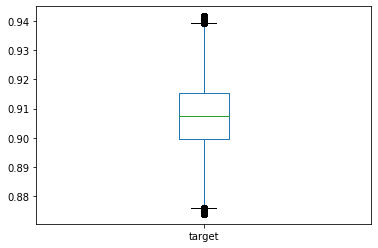

In [20]:
Q75 = df['target'].quantile(0.75)
Q25 = df['target'].quantile(0.25)
IQR = Q75 - Q25 
ub = Q75 + 1.5*IQR
lb = Q25 - 1.5*IQR
print(lb,ub)

out = (df['target']<lb)|(df['target']>ub)

df.loc[~out,'target'].plot(kind='box')

# Quantile

0.887653712828496 0.9282378891542071


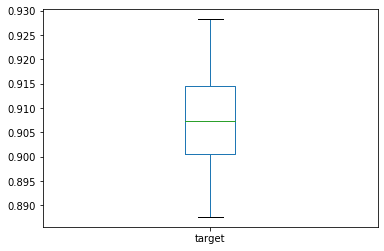

In [21]:
ub = df.loc[~out,'target'].quantile(0.95)
lb = df.loc[~out,'target'].quantile(0.05)
print(lb,ub)

out = (df['target']<lb)|(df['target']>ub)

df.loc[~out,'target'].plot(kind='box')

In [22]:
df['target_over_range'] = 0
df.loc[out|df['target'].isnull(),'target_over_range'] = 1

# save

In [23]:
df.head()

,MLPAP_TI-0706B03,MLPAP_TI-0706B07,MLPAP_TI-0706B20,MLPAP_TI-0706B14,MLPAP_LIC-0738.PV,MLPAP_TI-0706B11,MLPAP_TI-0706B19,MLPAP_TIC-0757.PV,DATA OF USE,MLPAP_TI-0706B04,...,MLPAP_TI-0706E01,MLPAP_TI-0706B06,MLPAP_TI-0706B17,MLPAP_TI-0706B24,MLPAP_TRC-0610.PV,MLPAP_FR-0755.PV,MLPAP_TJR-0715A1.PV,over_range_num,target,target_over_range
2016-05-09 00:00:00,401.962157,400.998932,400.795492,402.997679,23.912053,400.999089,402.998548,1.635430,3.342795,400.757148,...,400.994908,401.143639,401.951886,401.997668,199.928694,4.050917,402.689070,4,NaN,1
2016-05-09 00:10:00,401.939352,400.998932,400.795492,403.098684,23.912053,400.999089,402.998548,1.624784,3.342795,400.954632,...,400.994908,401.004025,401.830477,401.997668,199.928694,4.157893,402.778582,4,NaN,1
2016-05-09 00:20:00,401.905143,400.998932,400.751502,402.997679,23.912053,400.999089,402.998548,1.649624,3.342795,400.896549,...,400.994908,401.004025,401.764254,401.997668,199.928694,4.207893,402.728853,4,NaN,1
2016-05-09 00:30:00,401.950754,400.998932,400.949457,403.098684,23.912053,400.999089,402.998548,1.635430,3.342795,400.896549,...,400.994908,401.004025,401.996035,401.997668,199.928694,4.152079,403.166466,4,NaN,1
2016-05-09 00:40:00,401.996366,400.998932,401.004445,403.098684,23.912053,400.999089,402.998548,1.653172,3.342795,400.850082,...,400.994908,401.004025,401.709068,401.997668,199.928694,4.016615,403.017280,4,NaN,1


In [24]:
df.to_csv('./data/train_spec_checked(full).csv')